<a href="https://colab.research.google.com/github/bleenee203/IS335.P11---SQLi/blob/kthanh/Word2vec_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

# Mount drive and load data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data_path = '/content/drive/My Drive/Data/Modified_SQL_Dataset.csv'
data = pd.read_csv(data_path)

# Preprocess the Query data
data['Query'] = data['Query'].fillna('').apply(str)
queries = data['Query'].apply(lambda x: x.lower().split())
labels = data['Label'].values

# Step 2: Train Word2Vec Model
from gensim.models import Word2Vec
word2vec_model = Word2Vec(sentences=queries, vector_size=200, min_count=1, window=5, sg=1)

# Save word embeddings to use in LSTM
vocab_size = len(word2vec_model.wv)
embedding_dim = word2vec_model.vector_size

# Step 3: Prepare Data for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Query'])
sequences = tokenizer.texts_to_sequences(data['Query'])

# Padding sequences to ensure consistent input shape for LSTM
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Map Word2Vec embeddings to Keras Embedding layer
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Step 4: Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Add Dropout here
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))  # First Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Second Dropout before the output layer
model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the LSTM Model
y = labels  # Binary labels (1 or 0 for SQL injection classification)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X, y)
print(f"Accuracy: {accuracy}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9446 - loss: 0.1758 - val_accuracy: 0.9992 - val_loss: 0.0173
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9905 - loss: 0.0536 - val_accuracy: 0.9995 - val_loss: 0.0069
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9917 - loss: 0.0416 - val_accuracy: 0.9998 - val_loss: 0.0046
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9917 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9930 - loss: 0.0353 - val_accuracy: 0.9990 - val_loss: 0.0089
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9943 - loss: 0.0310 - val_accuracy: 0.9998 - val_loss: 0.0032
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9926 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9945 - loss: 0.0297 - val_accurac

In [ ]:
from sklearn.metrics import classification_report

# Step 1: Get model predictions on the validation/test set
y_pred = (model.predict(X) > 0.5).astype("int32")  # Use a threshold of 0.5 for binary classification

# Step 2: Print Precision, Recall, and F1-Score
print(classification_report(y, y_pred, target_names=['Non-SQL Injection', 'SQL Injection']))


967/967 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
                   precision    recall  f1-score   support

Non-SQL Injection       0.99      1.00      1.00     19537
    SQL Injection       1.00      0.98      0.99     11382

         accuracy                           0.99     30919
        macro avg       1.00      0.99      0.99     30919
     weighted avg       0.99      0.99      0.99     30919



check for overfitting

Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9950 - loss: 0.0229 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9953 - loss: 0.0230 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9955 - loss: 0.0218 - val_accuracy: 0.9998 - val_loss: 6.8986e-04
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9957 - loss: 0.0196 - val_accuracy: 0.9998 - val_loss: 5.8749e-04
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9956 - loss: 0.0210 - val_accuracy: 0.9997 - val_loss: 5.7090e-04
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9960 - loss: 0.0195 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9955 - loss: 0.0201 - val_accuracy: 0.9998 - val_loss: 2.5268e-04
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9952 -

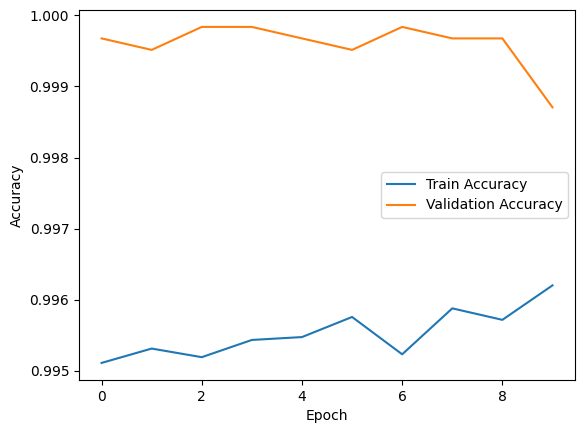

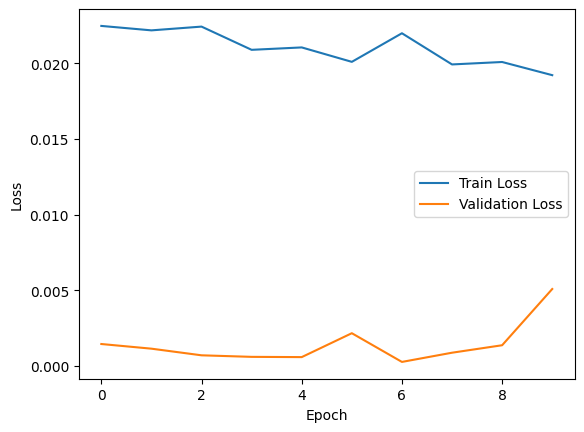

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **K-Fold Cross-Validation**

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
import pandas as pd

# Load data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/Modified_SQL_Dataset.csv'
data = pd.read_csv(data_path)

# Preprocess the Query data
data['Query'] = data['Query'].fillna('').apply(str)
queries = data['Query'].apply(lambda x: x.lower().split())
labels = data['Label'].values

# Step 2: Train Word2Vec Model
word2vec_model = Word2Vec(sentences=queries, vector_size=200, min_count=1, window=5, sg=1)
vocab_size = len(word2vec_model.wv)
embedding_dim = word2vec_model.vector_size

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Query'])
sequences = tokenizer.texts_to_sequences(data['Query'])
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Map Word2Vec embeddings to Keras Embedding layer
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Build LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix],
                        input_length=max_sequence_length, trainable=False))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    print(f'Training fold {fold_no}...')
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Fold {fold_no} - Accuracy: {accuracy}")
    accuracies.append(accuracy)
    fold_no += 1

# Print overall cross-validation accuracy
print(f'Average Cross-Validation Accuracy: {np.mean(accuracies)}')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training fold 1...
Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9627 - loss: 0.1494 - val_accuracy: 0.9905 - val_loss: 0.0501
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.9917 - loss: 0.0421 - val_accuracy: 0.9921 - val_loss: 0.0372
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9923 - loss: 0.0384 - val_accuracy: 0.9934 - val_loss: 0.0343
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9932 - loss: 0.0334 - val_accuracy: 0.9930 - val_loss: 0.0315
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9952 - loss: 0.0273 - val_accuracy: 0.9942 - val_loss: 0.0306
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9945 - loss: 0.0306 - val_accuracy: 0.9934 - val_loss: 0.0327
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.9956 - loss: 0.0248 - val_accuracy: 0.9932 - val_loss: 0.0300
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.995